In [6]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm.notebook import tqdm
%matplotlib inline
import random
import tensorflow as tf
from time import time

In [7]:
# Define drift and diffusion terms of stochastic process

def drift(x,kappa,theta):
    
    return kappa*(theta-x)


def diff(x,sigma):
    
    return sigma
    

In [8]:
# Function for Compound Poisson process for the jump term 

def normal_generator(mu_jump, sigma_jump, num_events):
    return np.random.normal(mu_jump, sigma_jump, num_events)

def compound_poisson_process(rate, dt, mu_jump, sigma_jump):
    num_events = np.random.poisson(rate*dt, size = 1)
    jumps = normal_generator(mu_jump = mu_jump, sigma_jump = sigma_jump, num_events = num_events)
    
    jump = jumps.sum()

    if len(jumps) == 0:
        jump = 0
        
    return jump

#mu_jump = 0.0
#sigma_jump = 1.0
#num_events_simulated = 50

#x = compound_poisson_process(10, 0.1, mu_jump, sigma_jump)
#plt.title("Sample Compound Poisson Process (Binomial)")
#plt.xlabel("time")
#plt.ylabel("events")
#plt.legend()

In [9]:
# Function for finite-horizon path simulation of jump OU process, with a given stopping value

def ou_jump_sim_stopping(kappa, theta, sigma, mu_jump, sigma_jump, rate, dt, x_0, n_sim, stopping, T):
    
    #T = 1.  # Total time.
    n = max(int(T / dt),1)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    x = np.zeros(n)
    x[0] = x_0
    x_origin = x
    x_list = list()
    ruin_count = 0
    
    for j in range(n_sim):
        
        if n-1 == 0:
            stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[0] <= stopping)) else 1.0
        else:
        
            for i in range(n - 1):

                stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[i] <= stopping)) else 1.0

                jump = compound_poisson_process(rate, dt, mu_jump, sigma_jump)
                #print(jump)

                x[i + 1] = x[i] + stopping_factor*(drift(x[i], kappa=kappa, theta=theta)*dt + diff(x[i], sigma = sigma)*np.sqrt(dt)*np.random.randn() \
                                + jump)


        #plt.plot(t, x, lw=1)
        x_list.append(x)
        
        x = x_origin
        
        if stopping_factor == 0.0:
                ruin_count += 1
        
        stopping_factor = 1.0
        
    ruin_prob = ruin_count / n_sim    
    #plt.show()
    
    return x_list, ruin_prob

   

In [10]:
# Run cells if you want to perform MC simulations

# sigma = 1.0 
# kappa = 0.5 
# theta = 0.1
# mu_jump = 0.0
# sigma_jump = 0.2
# rate = 1.0
# dt = 0.01
# x_0 = 0.9
# n_sim = 5000
# stopping = 0.0

# ou, prob = ou_jump_sim_stopping(kappa = kappa, theta = theta, sigma = sigma, mu_jump = mu_jump, sigma_jump = sigma_jump, rate = rate, 
#                  dt = dt, x_0 = x_0, n_sim = n_sim, stopping = stopping)
# print(prob)

In [11]:
# prob_list_ex = []

# for start in tqdm(np.linspace(0.0, 5.0, 51)):

#     kappa = 1.0
#     theta = 0.5
#     sigma = 1.0
#     mu_jump = 0.0
#     sigma_jump = 0.2
#     rate = 1.0
#     n_sim = 500
#     x_0 = start
#     stopping = 0.0
#     dt = 0.0001

#     ou, prob = ou_jump_sim_stopping(kappa = kappa, theta = theta, sigma = sigma, mu_jump = mu_jump, sigma_jump = sigma_jump, rate = rate, 
#                       dt = dt, x_0 = x_0, n_sim = n_sim, stopping = stopping)
    
#     prob_list_ex.append(prob)
    

#     print(x_0,prob)

In [12]:
#np.save('prob_ex_list_one.npy', np.array(prob_list_ex))

In [13]:
#prob_list_ex = np.load('prob_ex_list_one.npy')

In [14]:
# plt.plot(np.linspace(0.0, 5.0, 51), prob_list_ex)
# plt.show()

# Neural network ruin probability estimations

In [15]:
# Payoff function for default with 1 if the process has defaulted and 0 else

def g_func(path, stopping):
    
    #T = 1.  # Total time.
    #n = int(T / dt)  # Number of time steps.
    #t = np.linspace(0., T, n)
    
    #path, ruin = ou_sim_2(kappa, theta, sigma, dt, x_0, 1, stopping)
    
    #g = tf.constant(1.0) if (tf.math.reduce_any(path <= 0)) else tf.constant(0.0)
    g = tf.constant(1.0) if (np.any(np.array(path) <= 0)) else tf.constant(0.0)
    return g
    

In [16]:
from tqdm.notebook import tqdm

In [17]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
kappa = 0.5
theta = 3.5
sigma = 2.0
mu_jump = 0.0
sigma_jump = 0.2
rate = 1.0
stopping = 0.0
dt = 0.0001

# Set boundary values for initial position and convert to tensorflow
xmin = -10.0
xmax = 10.0

lb = tf.constant([xmin], dtype=DTYPE)
ub = tf.constant([xmax], dtype=DTYPE)


# Set random seed for reproducible results
tf.random.set_seed(100)

# Set number of path simulations
N_sim = 40000

# Draw random initial positions and maturity times for path simulations
X_0_data = tf.random.uniform((N_sim,1), lb, ub, dtype=DTYPE)
t_data = tf.random.uniform((N_sim,1), 0.0, 1.0, dtype = DTYPE) 

# Concatenate all parameters that will constitute model input into tensorflow format
process_data = tf.concat([X_0_data, t_data], axis=1)

# Simulate path for each (x,t) and append paths in list that will be used for training
path_data_list = []
for i in tqdm(range(len(X_0_data))):
    
    path_data, ruin =  ou_jump_sim_stopping(kappa = kappa, theta = theta, sigma = sigma, mu_jump = mu_jump, sigma_jump = sigma_jump, rate = rate, 
                 dt = dt, x_0 = X_0_data[i], n_sim = 1, stopping = stopping, T = t_data[i])
    
    
    path_data_list.append(path_data.copy())
    
## Make the paths a tensor for compatability with the NN architecture    
#path_data_list = tf.stack(path_data_not_tf)   

  0%|          | 0/40000 [00:00<?, ?it/s]

In [18]:
# Neural network parameters
num_hidden_layers = 2 #5 
num_neurons_per_layer = 50  #10

# Initializing the feedforwad neural network
model_jump = tf.keras.Sequential()

# Input is one-dimensional (only space & fixed time)
model_jump.add(tf.keras.Input(2))

# Scaling layer to map input to [lb, ub]
#scaling_layer = tf.keras.layers.Lambda(lambda x:
#                                      2.0*(x-lb)/(ub-lb)-1.0)
#model_jump.add(scaling_layer)

# Append hidden layers 
for _ in range(num_hidden_layers):
        model_jump.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('softplus'),
            kernel_initializer='glorot_uniform'))
        
# Output is one-dimensional
model_jump.add(tf.keras.layers.Dense(1))

In [19]:
# Compute loss functon.

def loss_function(model_jump, process_data, path_data_list):
    
    loss = 0.0
    
    for i in range(len(process_data)):
        
        path_values = path_data_list[i]
        g = g_func(path = path_values, stopping = 0.0)
     
        # Predict PD value
        pred = model_jump(process_data[i:(i+1)])
        # Compute loss as the squared difference between the payoff and model prediction (method by Frey)
        loss += tf.square(g - pred)
    
    # Final loss
    loss_value = loss / len(process_data)
    
    return loss_value    
    

In [20]:
# Function that computes the gradient of the loss function

def grad(model_jump, process_data, path_data_list):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model_jump.trainable_variables)
        loss_value = loss_function(model_jump, process_data, path_data_list)
    
    grad = tape.gradient(loss_value, model_jump.trainable_variables)
        
    del tape
    
    return loss_value, grad

In [21]:
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,4000,6000,8000],[1e-1,1e-2,1e-3,1e-4, 1e-5])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [22]:
from time import time

# Training step is a TensorFlow function (increases speed of training)
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = grad(model_jump, process_data, path_data_list)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model_jump.trainable_variables))
    
    return loss

In [23]:
# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in tqdm(range(N+1)):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%100 == 0:
        print('It{}: loss = {}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

  0%|          | 0/10001 [00:00<?, ?it/s]

It0: loss = [[1.6293434]]
It100: loss = [[0.02470037]]
It200: loss = [[0.02274799]]
It300: loss = [[0.02163024]]
It400: loss = [[0.0207615]]
It500: loss = [[0.02025927]]
It600: loss = [[0.02003521]]
It700: loss = [[0.01993953]]
It800: loss = [[0.01988692]]
It900: loss = [[0.01984766]]
It1000: loss = [[0.01981273]]
It1100: loss = [[0.01977781]]
It1200: loss = [[0.0197376]]
It1300: loss = [[0.01969475]]
It1400: loss = [[0.01966173]]
It1500: loss = [[0.01963634]]
It1600: loss = [[0.01961709]]
It1700: loss = [[0.01960252]]
It1800: loss = [[0.01959126]]
It1900: loss = [[0.01958226]]
It2000: loss = [[0.01967942]]
It2100: loss = [[0.01958105]]
It2200: loss = [[0.01957886]]
It2300: loss = [[0.01957766]]
It2400: loss = [[0.0195765]]
It2500: loss = [[0.01957532]]
It2600: loss = [[0.01957407]]
It2700: loss = [[0.0195728]]
It2800: loss = [[0.01957147]]
It2900: loss = [[0.01957015]]
It3000: loss = [[0.01956879]]
It3100: loss = [[0.01956741]]
It3200: loss = [[0.01956597]]
It3300: loss = [[0.01956455

In [1]:
#model_jump.save('NN_jump_t_input')

In [2]:
#model_jump = tf.keras.models.load_model('NN_jump_t_input')

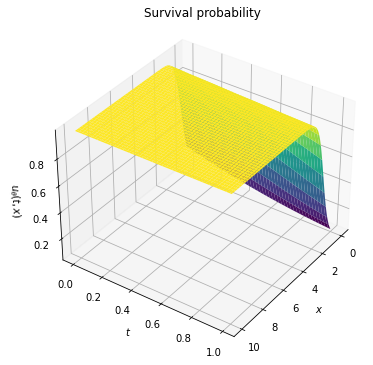

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, ub, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

# Determine predictions of u(t, x)
upred = model_jump(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = 1-upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Survival probability');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [26]:
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objects as go
N = 1000
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, ub, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T
upred = model_jump(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = 1-upred.numpy().reshape(N+1,N+1)

data=go.Surface(z=U, x=X, y=T, colorbar=None)

layout = go.Layout(scene = dict(
                    xaxis_title='Initial Position',
                    yaxis_title='Maturity time',
                    zaxis_title='Survival Probability'))

fig = go.Figure(data=[data], layout=layout)
pyoff.plot(fig)
#fig.show()

'temp-plot.html'

In [27]:
xspace_jump = np.linspace(lb, ub, 1001)
X = np.meshgrid(xspace_jump)
T = np.meshgrid([1.0]*len(xspace_jump))
Xgrid_jump = np.vstack([X, T]).T

In [28]:
upred_jump = model_jump(tf.cast(Xgrid_jump,DTYPE))

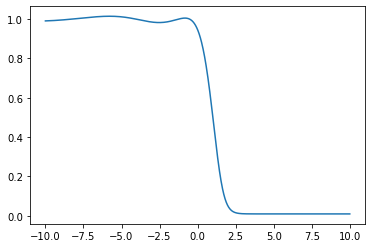

In [29]:
#upred = model_jump(tf.cast(Xgrid_jump,DTYPE))
plt.plot(xspace_jump, upred_jump)

In [37]:
xspace_jump = np.linspace(lb, ub, 1001)
X = np.meshgrid(xspace_jump)
T = np.meshgrid([0.0]*len(xspace_jump))
Xgrid_jump = np.vstack([X, T]).T

In [38]:
upred_jump = model_jump(tf.cast(Xgrid_jump,DTYPE))

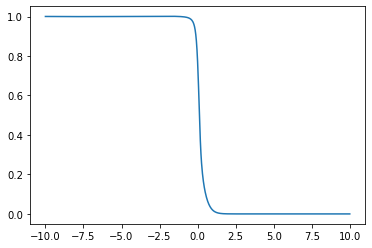

In [39]:
#upred = model_jump(tf.cast(Xgrid_jump,DTYPE))
plt.plot(xspace_jump, upred_jump)

In [40]:
# Comparison with MC

x_mc = np.linspace(0.0, 5.0, 51)
mc = prob_list_ex

fig, ax = plt.subplots()
ax.plot(x_mc, mc, label='MC estimation', color='blue')
ax.plot(xspace_jump, upred_jump, label='NN estimation', color = 'red')
legend = ax.legend(loc='center left')
plt.xlabel('x_0')
plt.ylabel('Psi-PD')
plt.title('Comparison of the different prices')
plt.show()

In [3]:
#other_model = tf.keras.models.load_model('NN_one')

In [4]:
# u = other_model(trial)
# u